In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
#from skopt import BayesSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import norm, skew
import sklearn.metrics as metrics
import math
#from skopt.space import Real, Integer


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


In [2]:
np.random.seed(42)

plt.rcParams.update({'figure.max_open_warning': 0})
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

In [3]:
def load_data():
    # Read data
    #data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv("train.csv", index_col="Id")
    df_test = pd.read_csv("test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


### Clean Data ###

Some of the categorical features in this dataset have what are apparently typos in their categories:

In [4]:
def clean(df):
    
    df["MSSubClass"] = df["MSSubClass"].astype("str") 
    df.loc[(df.MSZoning == "C (all)"), 'MSZoning'] = "C"
    df.loc[(df.MSZoning.isnull()) & (df.Neighborhood == "IDOTRR") & (df.MSSubClass == "20"), "MSZoning"] = "C"
    df.loc[(df.MSZoning.isnull()) & (df.Neighborhood == "Mitchel") & (df.MSSubClass == "20"), "MSZoning"] = "RL"
    
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Wd Shng": "WdShng"})
    df["Exterior2nd"] = df["Exterior2nd"].replace({"CmentBd": "CemntBd"})
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    df.loc[(df.GarageYrBlt == 2207), "GarageYrBlt"] = 2007
    df.loc[(df.GarageFinish.isnull()) & (df.GarageType.notnull()), "GarageFinish"] = "Fin"
    df.loc[(df.GarageCars.isnull()) & (df.GarageType.notnull()), "GarageCars"] = 1
    df.loc[(df.GarageQual.isnull()) & (df.GarageType.notnull()), "GarageQual"] = "TA"
    df.loc[(df.GarageCond.isnull()) & (df.GarageType.notnull()), "GarageCond"] = "TA"
    
    return df


### Encode the Statistical Data Type ###

Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. This hidden cell defines the `encode` function:

In [5]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", 
                "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
                "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
                "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [6]:
def impute(df):
    #Assume Typical
    df['SaleType'].fillna(value="Oth", inplace=True)
    df['Functional'].fillna(value="Typ", inplace=True)
    
    df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)
    df['GarageArea'].fillna(df['GarageArea'].mean(), inplace=True)

    
    for column in df[['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd']]:
        df[column].fillna(df[column].mode()[0], inplace=True)
    
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
        
    return df


## Load Data ##

And now we can call the data loader and get the processed data splits:

In [7]:
df_train, df_test = load_data()

In [8]:
# Peek at the values
#display(df_train)
#display(df_test)

# Display information about dtypes and missing values
#display(df_train.info())
#display(df_test.info())

## Establish Baseline ##

Finally, let's establish a baseline score to judge our feature engineering against.

Here is the function we created in Lesson 1 that will compute the cross-validated RMSLE score for a feature set. We've used XGBoost for our model, but you might want to experiment with other models.


In [9]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)

def score_dataset(X, y, model=XGBRegressor()): #
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    #cv = KFold(5,shuffle=True,random_state=42)
    log_y = np.log1p(y)
    score = cross_val_score(
        model, X, log_y, cv=cv, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

def score_dataset_lgb(X, y, model=LGBMRegressor()): #
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    #cv = KFold(5,shuffle=True,random_state=42)
    log_y = np.log1p(y)
    score = cross_val_score(
        model, X, log_y, cv=cv, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

def score_dataset_cat(X, y, model=CatBoostRegressor()): #
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    #cv = KFold(5,shuffle=True,random_state=42)
    log_y = np.log1p(y)
    score = cross_val_score(
        model, X, log_y, cv=cv, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score:

In [10]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")
#Baseline score: 0.14140 RMSLE

Baseline score: 0.13838 RMSLE


This baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

# Step 2 - Feature Utility Scores #

In Lesson 2 we saw how to use mutual information to compute a *utility score* for a feature, giving you an indication of how much potential the feature has. This hidden cell defines the two utility functions we used, `make_mi_scores` and `plot_mi_scores`: 

In [11]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Let's look at our feature scores again:

In [12]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual         5.714573e-01
Neighborhood        5.262205e-01
GrLivArea           4.303952e-01
YearBuilt           4.079737e-01
LotArea             3.944684e-01
TotalBsmtSF         3.685360e-01
GarageArea          3.615423e-01
GarageCars          3.523117e-01
BsmtQual            3.308034e-01
KitchenQual         3.246795e-01
ExterQual           3.240025e-01
FirstFlrSF          2.825031e-01
MSSubClass          2.813486e-01
YearRemodAdd        2.740316e-01
GarageYrBlt         2.722127e-01
FullBath            2.632172e-01
GarageFinish        2.624690e-01
LotFrontage         2.213011e-01
FireplaceQu         2.181614e-01
GarageType          2.115533e-01
TotRmsAbvGrd        2.084654e-01
Foundation          1.911287e-01
OpenPorchSF         1.902657e-01
Fireplaces          1.720900e-01
SecondFlrSF         1.675903e-01
HeatingQC           1.649465e-01
Exterior2nd         1.602566e-01
BsmtFinSF1          1.549404e-01
BsmtFinType1        1.536238e-01
Exterior1st         1.333076e-01
MSZoning  

You can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). As we talked about in Tutorial 2, the top scoring features will usually pay-off the most during feature development, so it could be a good idea to focus your efforts on those. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely:

In [13]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

Removing them does lead to a modest performance gain:

In [14]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)
#0.13971753806988094

0.13778256474818013

In [15]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X


In [16]:

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    #X['TotalSF'] = df['TotalBsmtSF'] + df['FirstFlrSF'] + df['SecondFlrSF']
    #X['OverallQualCond'] = df['OverallQual'].cat.codes * df['OverallCond'].cat.codes
    #X['ExterQualCond'] = df['ExterQual'].cat.codes * df['ExterCond'].cat.codes  
    #X['BsmtQualCond'] = df['BsmtQual'].cat.codes * df['BsmtCond'].cat.codes
    #X['GarageQualCond'] = df['GarageQual'].cat.codes * df['GarageCond'].cat.codes
    #X['OtherQualCond'] = df['HeatingQC'].cat.codes * df['KitchenQual'].cat.codes * df['FireplaceQu'].cat.codes
    
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X


Here are some ideas for other transforms you could explore:
- Interactions between the quality `Qual` and condition `Cond` features. `OverallQual`, for instance, was a high-scoring feature. You could try combining it with `OverallCond` by converting both to integer type and taking a product.
- Square roots of area features. This would convert units of square feet to just feet.
- Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
- Interactions between numeric and categorical features that describe the same thing. You could look at interactions between `BsmtQual` and `TotalBsmtSF`, for instance.
- Other group statistics in `Neighboorhood`. We did the median of `GrLivArea`. Looking at `mean`, `std`, or `count` could be interesting. You could also try combining the group statistics with other features. Maybe the *difference* of `GrLivArea` and the median is important?

## k-Means Clustering ##

The first unsupervised algorithm we used to create features was k-means clustering. We saw that you could either use the cluster labels as a feature (a column with `0, 1, 2, ...`) or you could use the *distance* of the observations to each cluster. We saw how these features can sometimes be effective at untangling complicated spatial relationships.

In [17]:

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd


## Principal Component Analysis ##

PCA was the second unsupervised model we used for feature creation. We saw how it could be used to decompose the variational structure in the data. The PCA algorithm gave us *loadings* which described each component of variation, and also the *components* which were the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly.

Here are the utility functions from the PCA lesson:

In [18]:

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


And here are transforms that produce the features from the Exercise 5. You might want to change these if you came up with a different answer.


In [19]:

def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

These are only a couple ways you could use the principal components. You could also try clustering using one or more components. One thing to note is that PCA doesn't change the distance between points -- it's just like a rotation. So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, you might want to look at a correlation matrix for the dataset:

<AxesSubplot:>

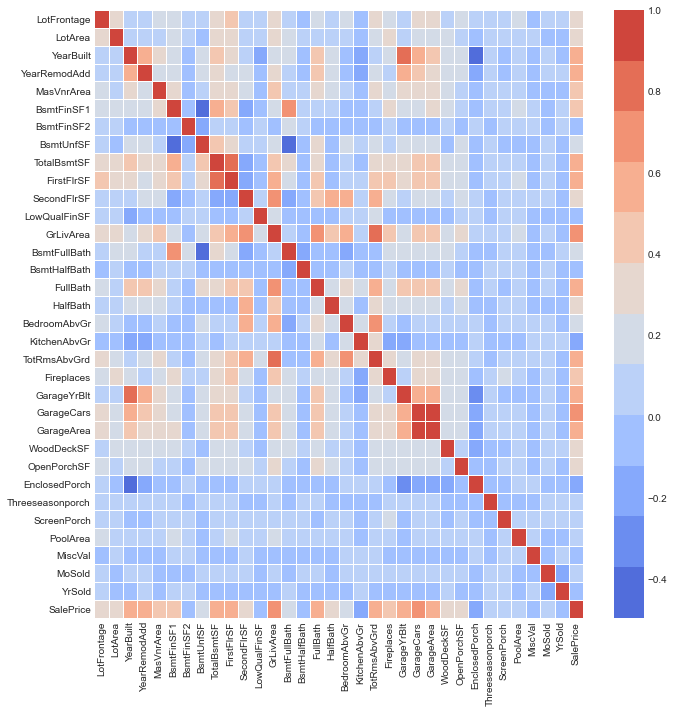

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
colormap = sns.color_palette("coolwarm", 12)#("viridis", as_cmap=True)
sns.heatmap(df_train.corr(), linewidths=.5, ax=ax, cmap=colormap)

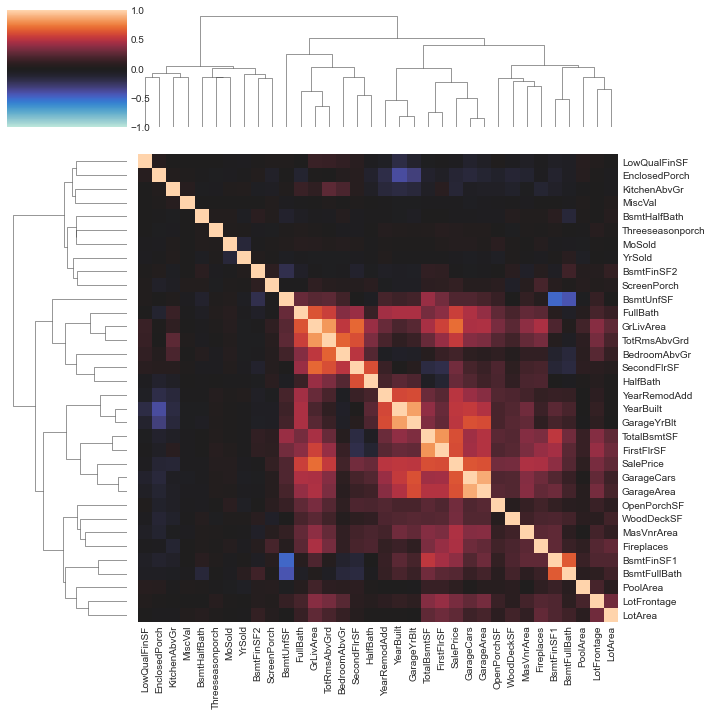

In [20]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

Groups of highly correlated features often yield interesting loadings.

### PCA Application - Indicate Outliers ###

In Exercise 5, you applied PCA to determine houses that were **outliers**, that is, houses having values not well represented in the rest of the data. You saw that there was a group of houses in the `Edwards` neighborhood having a `SaleCondition` of `Partial` whose values were especially extreme.

Some models can benefit from having these outliers indicated, which is what this next transform will do.

In [21]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new


You could also consider applying some sort of robust scaler from scikit-learn's `sklearn.preprocessing` module to the outlying values, especially those in `GrLivArea`. [Here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) is a tutorial illustrating some of them. Another option could be to create a feature of "outlier scores" using one of scikit-learn's [outlier detectors](https://scikit-learn.org/stable/modules/outlier_detection.html).

## Target Encoding ##

Needing a separate holdout set to create a target encoding is rather wasteful of data. In *Tutorial 6* we used 25% of our dataset just to encode a single feature, `Zipcode`. The data from the other features in that 25% we didn't get to use at all.

There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:
1. Split the data into folds, each fold having two splits of the dataset.
2. Train the encoder on one split but transform the values of the other.
3. Repeat for all the splits.

This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In the next hidden cell is a wrapper you can use with any target encoder:

In [22]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


Use it like:

```
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))
```

You can turn any of the encoders from the [`category_encoders`](http://contrib.scikit-learn.org/category_encoders/) library into a cross-fold encoder. The [`CatBoostEncoder`](http://contrib.scikit-learn.org/category_encoders/catboost.html) would be worth trying. It's similar to `MEstimateEncoder` but uses some tricks to better prevent overfitting. Its smoothing parameter is called `a` instead of `m`.

## Create Final Feature Set ##

Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. The ones I left uncommented I found gave the best results. You should experiment with you own ideas though! Modify any of these transformations or come up with some of your own to add to the pipeline.

In [23]:
#print("Top 20 MI:")
#print(mi_scores.head(20))
#print("\n")
#print("Bootom 20 MI:")
#print(mi_scores.tail(20))  # uncomment to see bottom 20

#plt.figure(dpi=100, figsize=(8, 5))
#plot_mi_scores(mi_scores.head(20))
#plt.figure(dpi=100, figsize=(8, 5))
#plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [24]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    #X = drop_uninformative(X, mi_scores)
    

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    #X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    #X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    #X = X.join(pca_components(X, pca_features))
    X = X.join(indicate_outliers(X))

    X = label_encode(X)
    
    drop_columns = ["MSSubClass", "Neighborhood", "Condition1", "Condition2", "Exterior1st", "Exterior2nd", 
                    "PoolArea", "PoolQC", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "Threeseasonporch", 
                    "ScreenPorch", "LowQualFinSF", "MiscVal", "SecondFlrSF","HouseStyle","YrSold", "MoSold", 
                    "YearBuilt", "YearRemodAdd", "GarageYrBlt", "Utilities", "Street"]
    X.drop(drop_columns, axis=1, inplace=True)
    
    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    #encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    #X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    #if df_test is not None:
    #    X_test = X_test.join(encoder.transform(X_test))

    #Skewed
    numeric_feats = X.dtypes[X.dtypes != 'category'].index
    skewed_feats = X[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    
    for feature in high_skew.index:
        X[feature] = np.log1p(X[feature])

    if df_test is not None:
        numeric_feats = X_test.dtypes[X_test.dtypes != 'category'].index
        skewed_feats = X_test[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
        high_skew = skewed_feats[abs(skewed_feats) > 0.5]
        #high_skew
    
        for feature in high_skew.index:
            X_test[feature] = np.log1p(X_test[feature])
       
    #Robust Scaler
    scaler = RobustScaler()
    
    predictors_cols = X.columns
    X[predictors_cols] = scaler.fit_transform(X[predictors_cols])
    
    if df_test is not None:
        X_test[predictors_cols] = scaler.transform(X_test[predictors_cols])
    
    #Variance Threshold
    selector = VarianceThreshold(0.01)

    selector.fit(X)
    X = X[X.columns[selector.get_support()]]
    
    if df_test is not None:
        selector.transform(X_test)
        X_test = X_test[X_test.columns[selector.get_support()]]
    
    #Return train and test if df_test is not none
    if df_test is not None:  
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)
#0.1381925629969659 - base code
#0.13676280642647218
#0.13523478607153136 kfold15
#0.1361375532217599 kfold10

0.13304020995016141

# Step 4 - Hyperparameter Tuning #

At this stage, you might like to do some hyperparameter tuning with XGBoost before creating your final submission.

In [25]:
xgb_params = dict(
    random_state=42, 
    max_depth=4,
    learning_rate=0.003519434617186593, 
    n_estimators=7830, 
    min_child_weight=2, 
    colsample_bytree=0.9892180785433881, 
    subsample=0.3782508236463379, 
    reg_alpha=0.00022374959041048762, 
    reg_lambda=0.00010238969999451745
)

xgb = XGBRegressor(**xgb_params)
#score_dataset(X_train, y_train, xgb)
#0.12414985267470383 base code
#0.11600026478351594 - lowest
#last run - 0.13106570429131176
#0.11812233207712444 kfold10 

In [26]:
lgb_params = dict(colsample_bytree=0.25, learning_rate=0.01,
                              max_depth=13, min_child_samples=7, n_estimators=10000,
                              num_leaves=20, objective='regression', random_state=42,
                              subsample=0.9330025956033094, subsample_freq=1
                 )

lgb = LGBMRegressor(**lgb_params)

cat_params = dict(n_estimators=2811,
                  loss_function='RMSE',
                  colsample_bylevel=0.37610293699831,
                  max_leaves=31,
                  subsample=0.5524703486729446,
                  verbose=0,
                  thread_count=6,
                  random_state=838
                 )
cat = CatBoostRegressor(**cat_params)
                 

In [27]:
df_train, df_test = load_data()
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

#%%time
models = {
    "LGBMRegressor": lgb,
    "XGBRegressor": xgb,
    "CatBoostRegressor": cat
         }

oof_df = pd.DataFrame()
predictions_df = pd.DataFrame()


for name, model in models.items():
    
    print("For model ", name, "\n")
    i = 1
    oof = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    
    for train_ix, test_ix in cv.split(X_train):
        
        print("Out of fold predictions generating for fold ", i)
                
        train_X, train_y = X_train.iloc[train_ix], y_train.iloc[train_ix]
        test_X, test_y = X_train.iloc[test_ix], y_train.iloc[test_ix]
        
        if name == "LGBMRegressor":
            model.fit(train_X, np.log1p(train_y),
                      eval_set = [(test_X, test_y)],
                      eval_metric = "rmse",
                      early_stopping_rounds=200,
                      verbose=0)
            
        elif name == "XGBRegressor":
            model.fit(train_X, np.log1p(train_y),
                      eval_set = [(test_X, test_y)],
                      eval_metric = "rmse",
                      early_stopping_rounds=200,
                      verbose=0)
        else:
            #model.fit(train_X, train_y)
            model.fit(train_X, np.log1p(train_y),
            eval_set = [(test_X, test_y)],
            #loss_function = "rmse",
            early_stopping_rounds=200,
            verbose=0)
            
        oof[test_ix] = oof[test_ix] + model.predict(X_train.values[test_ix])
        predictions = predictions + model.predict(X_test.values)
        
        i = i + 1
        
        oof_df[name] = oof
        predictions_df[name] = predictions / 10
        
        
    print("\nDone \n")

For model  LGBMRegressor 

Out of fold predictions generating for fold  1
Out of fold predictions generating for fold  2
Out of fold predictions generating for fold  3
Out of fold predictions generating for fold  4
Out of fold predictions generating for fold  5
Out of fold predictions generating for fold  6
Out of fold predictions generating for fold  7
Out of fold predictions generating for fold  8
Out of fold predictions generating for fold  9
Out of fold predictions generating for fold  10

Done 

For model  XGBRegressor 

Out of fold predictions generating for fold  1
Out of fold predictions generating for fold  2
Out of fold predictions generating for fold  3
Out of fold predictions generating for fold  4
Out of fold predictions generating for fold  5
Out of fold predictions generating for fold  6
Out of fold predictions generating for fold  7
Out of fold predictions generating for fold  8
Out of fold predictions generating for fold  9
Out of fold predictions generating for fold  

In [28]:
predictions_df

,LGBMRegressor,XGBRegressor,CatBoostRegressor
0,11.781145,11.757235,11.787010
1,12.030427,12.028734,12.039856
2,12.183261,12.141423,12.210129
3,12.167575,12.132281,12.208647
4,12.202422,12.184711,12.193061
...,...,...,...
1454,11.349147,11.328923,11.361464
1455,11.393815,11.369941,11.408590
1456,11.893966,11.860548,11.937243
1457,11.682890,11.661252,11.694857


In [29]:
preds = (np.expm1(predictions_df["LGBMRegressor"].values) + np.expm1(predictions_df["XGBRegressor"].values)
 + np.expm1(predictions_df["CatBoostRegressor"].values))/3

sub = pd.DataFrame({"Id": X_test.index, "SalePrice": preds})
#sub.to_csv("BlendedModel120121.csv", index = False)

sub

,Id,SalePrice
0,1461,129988.971283
1,1462,168217.246120
2,1463,194592.792148
3,1464,192910.847766
4,1465,197485.270516
...,...,...
1454,2915,84676.136854
1455,2916,88512.323436
1456,2917,146934.038566
1457,2918,118155.236219


In [30]:
#ewan2

In [31]:
df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    random_state=42, 
    max_depth=4,
    learning_rate=0.003519434617186593, 
    n_estimators=7830, 
    min_child_weight=2, 
    colsample_bytree=0.9892180785433881, 
    subsample=0.3782508236463379, 
    reg_alpha=0.00022374959041048762, 
    reg_lambda=0.00010238969999451745
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.11781165660429124

In [32]:
df_train, df_test = load_data()
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
#lgb = LGBMRegressor(**lgb_params)
#cat = CatBoostRegressor(**cat_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log1p(y))
xgb_predictions = np.expm1(xgb.predict(X_test))

xgb_output = pd.DataFrame({'Id': X_test.index, 'SalePrice': xgb_predictions})
xgb_output.to_csv('xgb_submission.csv', index=False)
print("Your submission was successfully saved!")
print(xgb_output)

Your submission was successfully saved!
        Id      SalePrice
0     1461  137879.109375
1     1462  180018.687500
2     1463  203685.937500
3     1464  199760.750000
4     1465  206160.265625
...    ...            ...
1454  2915   83214.218750
1455  2916   89997.210938
1456  2917  147602.171875
1457  2918  123734.273438
1458  2919  217193.890625

[1459 rows x 2 columns]


In [33]:
df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

lgb_params = dict(colsample_bytree=0.25, learning_rate=0.01,
                              max_depth=13, min_child_samples=7, n_estimators=10000,
                              num_leaves=20, objective='regression', random_state=42,
                              subsample=0.9330025956033094, subsample_freq=1
                 )

lgb = LGBMRegressor(**lgb_params)
score_dataset_lgb(X_train, y_train, lgb)
#0.11865468816560916

0.11961105904518936

In [34]:
df_train, df_test = load_data()
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

#xgb = XGBRegressor(**xgb_params)
lgb = LGBMRegressor(**lgb_params)
#cat = CatBoostRegressor(**cat_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
lgb.fit(X_train, np.log1p(y))
lgb_predictions = np.expm1(lgb.predict(X_test))

lgb_output = pd.DataFrame({'Id': X_test.index, 'SalePrice': lgb_predictions})
lgb_output.to_csv('lgb_submission.csv', index=False)
print("Your submission was successfully saved!")
print(lgb_output)

Your submission was successfully saved!
        Id      SalePrice
0     1461  133269.151041
1     1462  170239.214346
2     1463  201851.211044
3     1464  196223.407358
4     1465  197497.413081
...    ...            ...
1454  2915   83272.562834
1455  2916   89942.346035
1456  2917  143508.390101
1457  2918  118225.329163
1458  2919  217278.154540

[1459 rows x 2 columns]


In [35]:
"""
import optuna

def objective(trial):
    X_train = create_features(df_train)
    y_train = df_train.loc[:, "SalePrice"]

    cat_params_2 = dict(n_estimators=trial.suggest_int("n_estimators", 1000, 3200),
                  loss_function='RMSE',
                  colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.2, 1.0),
                  max_leaves=31,
                  subsample=trial.suggest_float("subsample", 0.2, 1.0),
                  #depth=trial.suggest_int("depth", 1, 12),
                  verbose=0,
                  thread_count=6,
                  random_state=trial.suggest_int("random_state", 1, 1234)
                 )

    cat_2 = CatBoostRegressor(**cat_params_2)

    return score_dataset(X_train, y_train, cat_2)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
"""

'\nimport optuna\n\ndef objective(trial):\n    X_train = create_features(df_train)\n    y_train = df_train.loc[:, "SalePrice"]\n\n    cat_params_2 = dict(n_estimators=trial.suggest_int("n_estimators", 1000, 3200),\n                  loss_function=\'RMSE\',\n                  colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.2, 1.0),\n                  max_leaves=31,\n                  subsample=trial.suggest_float("subsample", 0.2, 1.0),\n                  #depth=trial.suggest_int("depth", 1, 12),\n                  verbose=0,\n                  thread_count=6,\n                  random_state=trial.suggest_int("random_state", 1, 1234)\n                 )\n\n    cat_2 = CatBoostRegressor(**cat_params_2)\n\n    return score_dataset(X_train, y_train, cat_2)\n\n\nstudy = optuna.create_study(direction="minimize")\nstudy.optimize(objective, n_trials=50)\n\ntrial = study.best_trial\nprint(\'Accuracy: {}\'.format(trial.value))\nprint("Best hyperparameters: {}".format(trial.params))\

In [36]:
#Accuracy: 0.11544173454352033
#Best hyperparameters: {'n_estimators': 2811, 'colsample_bylevel': 0.376102936998312, 
#'subsample': 0.5524703486729446, 'random_state': 838}
df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

cat_params = dict(n_estimators=2811,
                  loss_function='RMSE',
                  colsample_bylevel=0.37610293699831,
                  max_leaves=31,
                  subsample=0.5524703486729446,
                  verbose=0,
                  thread_count=6,
                  random_state=838
                 )

cat = CatBoostRegressor(**cat_params)
score_dataset_lgb(X_train, y_train, cat)
#0.11542671550280206


0.11755420190991481

In [37]:
df_train, df_test = load_data()
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

#xgb = XGBRegressor(**xgb_params)
#lgb = LGBMRegressor(**lgb_params)
cat = CatBoostRegressor(**cat_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
cat.fit(X_train, np.log1p(y))
cat_predictions = np.expm1(cat.predict(X_test))

cat_output = pd.DataFrame({'Id': X_test.index, 'SalePrice': cat_predictions})
cat_output.to_csv('cat_submission.csv', index=False)
print("Your submission was successfully saved!")
print(cat_output)

Your submission was successfully saved!
        Id      SalePrice
0     1461  129990.256979
1     1462  171804.517873
2     1463  201384.863589
3     1464  198857.419017
4     1465  197887.980228
...    ...            ...
1454  2915   85957.609397
1455  2916   88632.045128
1456  2917  150446.051907
1457  2918  122389.581401
1458  2919  218607.589275

[1459 rows x 2 columns]


	Id	SalePrice top 13 
count	1459.000000	1459.000000

mean	2190.000000	177411.549638

std	421.321334	75177.613937

min	1461.000000	44460.169923

25%	1825.500000	128180.806339

50%	2190.000000	156585.004598

75%	2554.500000	207684.559092

max	2919.000000	486245.759692


	Id	SalePrice top 12
count	1459.000000	1459.000000

mean	2190.000000	177499.877891

std	421.321334	75348.611850

min	1461.000000	43992.328466

25%	1825.500000	128077.862000

50%	2190.000000	156291.817305

75%	2554.500000	207770.154323

max	2919.000000	517551.489506

In [38]:
output = pd.DataFrame({'Id': X_test.index, 
                       'SalePrice': ((cat_predictions + lgb_predictions + xgb_predictions) / 3)})
output.to_csv('all_submission.csv', index=False)
print("Your submission was successfully saved!")
print(output)

Your submission was successfully saved!
        Id      SalePrice
0     1461  133712.839132
1     1462  174020.806573
2     1463  202307.337378
3     1464  198280.525458
4     1465  200515.219645
...    ...            ...
1454  2915   84148.130327
1455  2916   89523.867367
1456  2917  147185.537961
1457  2918  121449.728001
1458  2919  217693.211480

[1459 rows x 2 columns]


In [39]:
#xgb_output